In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
df = pd.read_csv('data.csv')

In [33]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Train decision tree with default parameters

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt', DecisionTreeRegressor(random_state=42))])

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

def print_metrics(mse, mae, r2):
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R2: {r2:.3f}')

In [37]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 0.000
MAE: 0.000
R2: 1.000

Test Set:
MSE: 9.372
MAE: 2.131
R2: 0.805


In [42]:
default_model = model

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.79399773 0.79941775 0.79144076 0.78148488 0.78076705]
R^2 trung bình: 0.789 ± 0.007

MSE: [10.01699164  9.64651811 10.09640568 10.32070215 10.76427974]
MSE trung bình: 10.169± 0.368

MAE: [2.14958217 2.12451253 2.14767345 2.1395932  2.16857063]
MAE trung bình: 2.146 ± 0.014


In [31]:
max_depths = np.arange(1, 21)
mse_train_values, mse_test_values = [], []
mae_train_values, mae_test_values = [], []
r2_train_values, r2_test_values = [], []

for depth in max_depths:
    model = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(max_depth=depth))
    ])
    model.fit(X_train, y_train)
    
    mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
    mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)

    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)

    mae_train_values.append(mae_train)
    mae_test_values.append(mae_test)
    
    r2_train_values.append(r2_train)
    r2_test_values.append(r2_test)

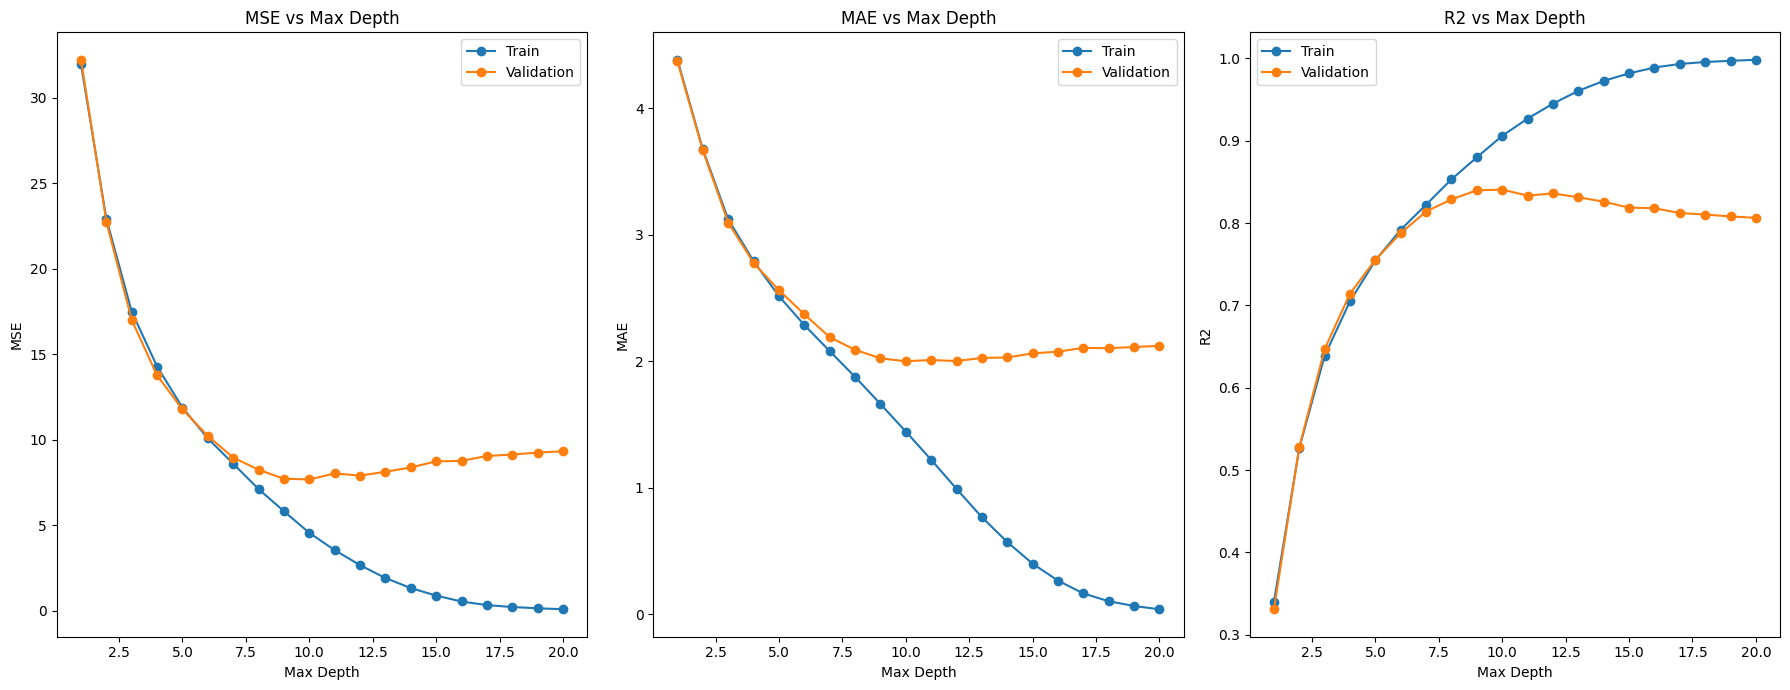

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 7))

plt.subplot(1, 3, 1)
plt.plot(max_depths, mse_train_values, label='Train', marker='o')
plt.plot(max_depths, mse_test_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE vs Max Depth')

plt.subplot(1, 3, 2)
plt.plot(max_depths, mae_train_values, label='Train', marker='o')
plt.plot(max_depths, mae_test_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE vs Max Depth')

plt.subplot(1, 3, 3)
plt.plot(max_depths, r2_train_values, label='Train', marker='o')
plt.plot(max_depths, r2_test_values, label='Validation', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('R2')
plt.legend()
plt.title('R2 vs Max Depth')

plt.tight_layout()
plt.show()

As we can see here, the decision tree is completely fitted to our training data, leading to a "perfect" result. However, it does not perform well on the validation and test sets, which is a sign of **overfitting**. 

# Pruning decision tree having max_depth = 13

In [15]:
import pandas as pd
df = pd.read_csv('data.csv')

In [16]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
model = DecisionTreeRegressor(random_state=42, max_depth=13)

path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas[:-1], path.impurities[:-1]

ccp_alphas.shape, impurities.shape

((2656,), (2656,))

In [40]:
ccp_alphas

array([0.00000000e+00, 3.98025792e-05, 3.98025792e-05, ...,
       2.44285898e+00, 2.79889466e+00, 6.60340123e+00])

In [41]:
df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
from sklearn.model_selection import cross_val_score

trees = []
scores = []

for ccp_alpha in ccp_alphas:
    tree = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha))
    ])
    tree.fit(X_train, y_train)
    trees.append(tree)

    score = cross_val_score(tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    scores.append(np.mean(score))

MSE_train = [mean_squared_error(y_train, tree.predict(X_train)) for tree in trees]
MSE_test = [mean_squared_error(y_test, tree.predict(X_test)) for tree in trees]

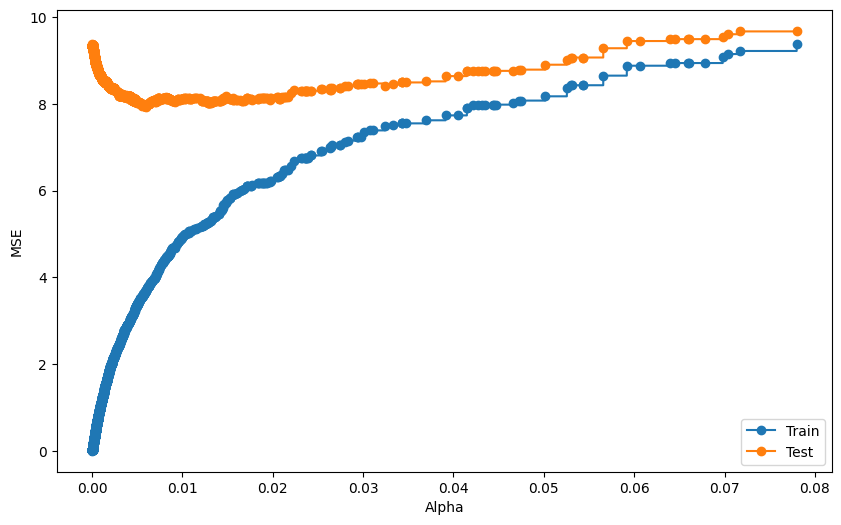

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Alpha')
ax.set_ylabel('MSE')
    
ax.plot(ccp_alphas[:2620], MSE_train[:2620], marker='o', label='Train', drawstyle='steps-post')
ax.plot(ccp_alphas[:2620], MSE_test[:2620], marker='o', label='Test', drawstyle='steps-post')

ax.legend()
plt.show()

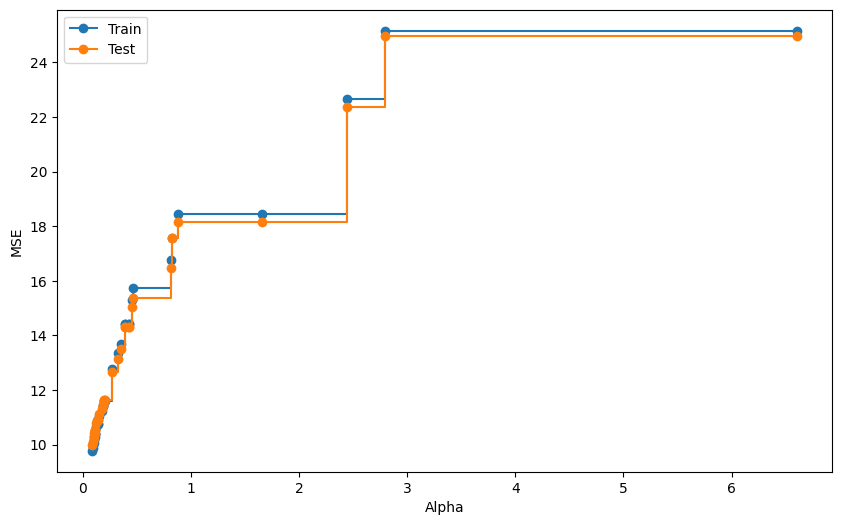

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Alpha')
ax.set_ylabel('MSE')
    
ax.plot(ccp_alphas[2620:], MSE_train[2620:], marker='o', label='Train', drawstyle='steps-post')
ax.plot(ccp_alphas[2620:], MSE_test[2620:], marker='o', label='Test', drawstyle='steps-post')

ax.legend()
plt.show()

Best alpha: 0.014447222009716376
Best MSE: 8.84037783627623


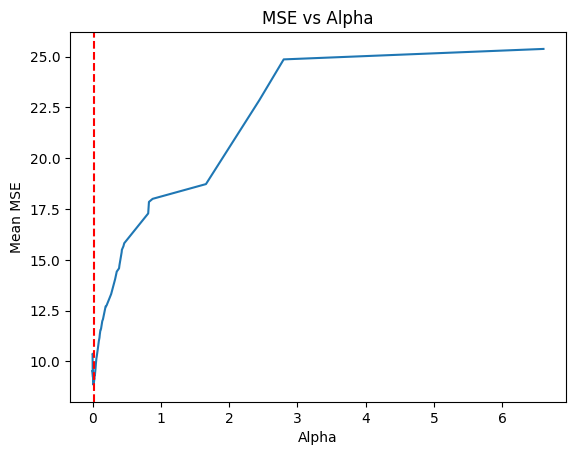

In [45]:
scores = [-score for score in scores]

plt.plot(ccp_alphas[:], scores[:])
plt.xlabel('Alpha')
plt.ylabel('Mean MSE')
plt.title('MSE vs Alpha')

best_idx = np.argmin(scores)
plt.axvline(x=ccp_alphas[best_idx], color='r', linestyle='--', label=f'Best Alpha: {ccp_alphas[best_idx]:.4f}')

print(f"Best alpha: {ccp_alphas[best_idx]}")
print(f"Best MSE: {scores[best_idx]}")

In [18]:
model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alphas[best_idx], max_depth=13))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=0.014447222009716376,
                                       max_depth=13, random_state=42))])

In [44]:
pruning_model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(ccp_alpha=0.014447222009716376, max_depth=13,
                      random_state=42))
])
pruning_model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=0.014447222009716376,
                                       max_depth=13, random_state=42))])

In [19]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 5.647
MAE: 1.812
R2: 0.883

Test Set:
MSE: 8.082
MAE: 2.085
R2: 0.832


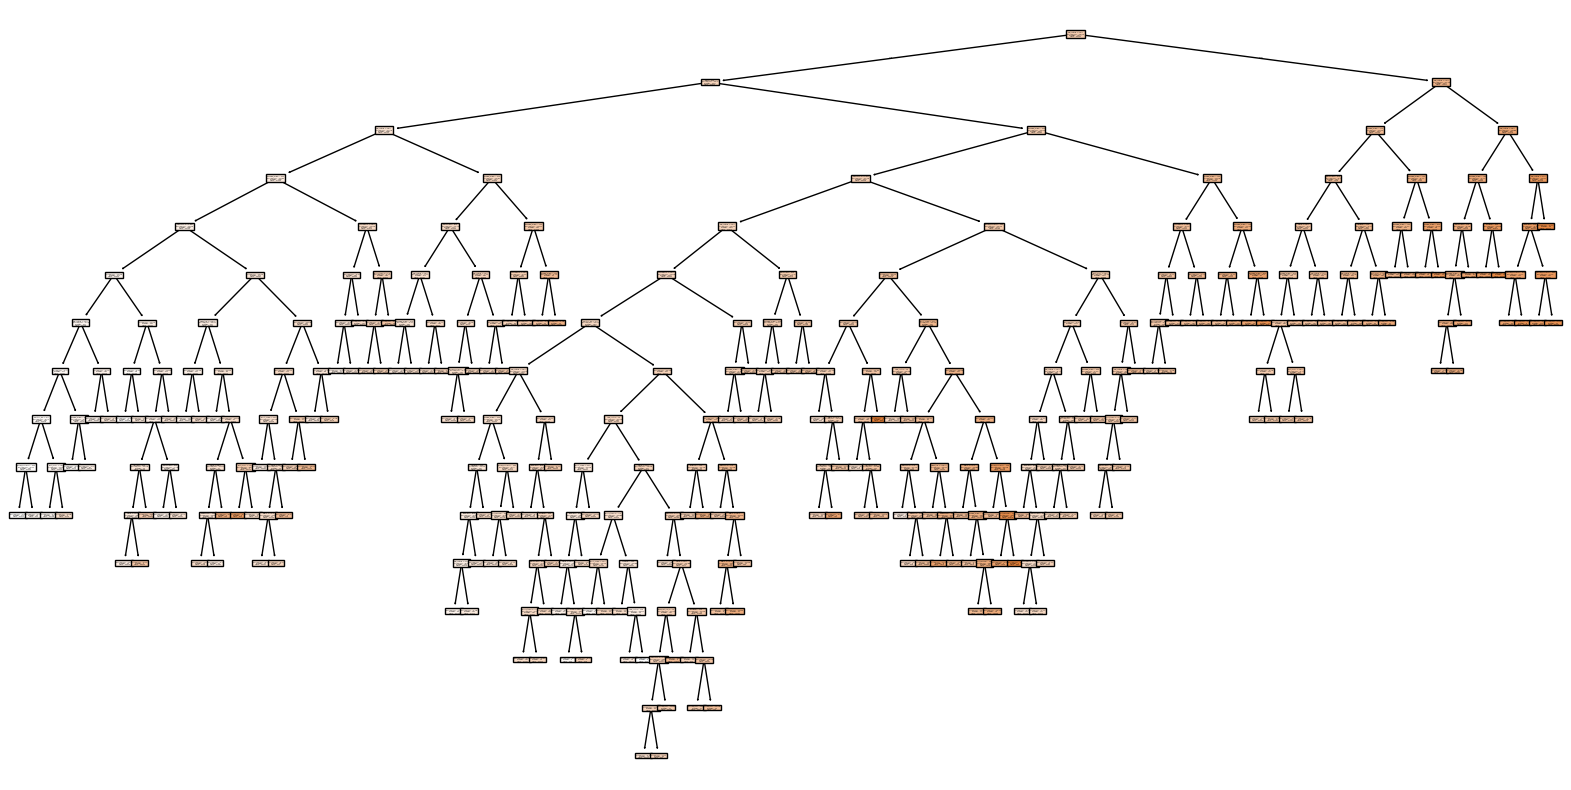

In [48]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model.named_steps['dt'], filled=True, feature_names=X.columns)
plt.show()

## Cross validation to evaluate model after pruning

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.83369975 0.83052335 0.83405555 0.81407873 0.8186762 ]
R^2 trung bình: 0.826 ± 0.008

MSE: [8.08645531 8.15056958 8.03341306 8.78126006 8.90295032]
MSE trung bình: 8.391± 0.372

MAE: [2.09266545 2.06677675 2.06806954 2.1168852  2.1415223 ]
MAE trung bình: 2.097 ± 0.029


# Genetic algorithm to find optimal decision tree

In [52]:
import pandas as pd

df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [88]:
def create_individual():
    max_depth = np.random.randint(1, 30)
    min_samples_split = np.random.randint(2, 100)
    ccp_alpha = np.random.uniform(0, 0.01)
    while True:
        min_samples_leaf = np.random.randint(1, 50)
        if min_samples_leaf * 2 <= min_samples_split:
            break
    return [max_depth, min_samples_split, ccp_alpha, min_samples_leaf]

def fitness(individual):
    max_depth, min_samples_split, ccp_alpha, min_samples_leaf = individual
    
    model = Pipeline([
        ('te', TargetEncoder(cols=['nationality'])),
        ('dt', DecisionTreeRegressor(
            random_state=42, 
            max_depth=max_depth, 
            min_samples_split=min_samples_split,
            ccp_alpha=ccp_alpha,
            min_samples_leaf=min_samples_leaf
        ))
    ])
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    return -scores.mean(),

def create_population(pop_size):
    return [create_individual() for _ in range(pop_size)]

def crossover(ind1, ind2, crossover_rate=0.9):
    child1, child2 = ind1[:], ind2[:]
    if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(1, len(ind1))
        child1 = ind1[:crossover_point] + ind2[crossover_point:]
        child2 = ind2[:crossover_point] + ind1[crossover_point:]
        # for i in range(len(ind1)):
        #     if np.random.rand() < 0.5:
        #         child1[i], child2[i] = child2[i], child1[i]
    def check(child):
        min_samples_split = child[1]
        min_samples_leaf = child[3]
        if min_samples_leaf * 2 > min_samples_split:
            child[3] = min_samples_split // 2
        return child
    child1 = check(child1)
    child2 = check(child2)
    return child1, child2

def mutate(individual, mutation_rate=0.05):
    # if np.random.rand() < mutation_rate:
    #     mutation_point = np.random.randint(0, len(individual))
    #     if mutation_point == 0:
    #         individual[mutation_point] = np.random.randint(1, 30)
    #     elif mutation_point == 1:
    #         individual[mutation_point] = np.random.randint(2, 100)
    #     elif mutation_point == 2:
    #         individual[mutation_point] = np.random.uniform(0, 0.1)
    #     else:
    #         while True:
    #             individual[mutation_point] = np.random.randint(1, 50)
    #             if individual[mutation_point] * 2 <= individual[1]:
    #                 break
    # return individual
    mutated = individual[:]
    for i in range(len(mutated)):
        if np.random.rand() < mutation_rate:
            if i != 3:
                mutated[i] = create_individual()[i]
            else:
                while True:
                    mutated[i] = np.random.randint(1, 50)
                    if mutated[i] * 2 <= mutated[1]:
                        break
    return mutated

In [89]:
def genetic_algorithm(pop_size, generations, generations_values, fitness_values):
    population = create_population(pop_size)

    for generation in range(generations):
        scores = [fitness(ind) for ind in population]
        sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]

        print(f'Generation {generation + 1}: Best MSE: {scores[0][0]:.3f}')
        print(f'Solution: {sorted_population[0]}')

        generations_values.append(generation + 1)
        fitness_values.append(-scores[0][0])

        # Elitism
        parents = sorted_population[:5]
        # print('Parents:\n', parents)

        next_generation = parents[:]

        while len(next_generation) < pop_size:
            # Selection
            idx1 = np.random.randint(0, len(parents))
            while True:
                idx2 = np.random.randint(0, len(parents))
                if idx2 != idx1:
                    break
            parent1, parent2 = parents[idx1], parents[idx2]

            # Crossover
            child1, child2 = crossover(parent1, parent2)

            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)

            next_generation.append(child1)
            next_generation.append(child2)

        population = next_generation
    
    scores = [fitness(ind) for ind in population]
    # print(scores)
    sorted_population = [ind for ind, score in sorted(zip(population, scores), key=lambda x: x[1])]
    return sorted_population[0]

In [90]:
pop_size = 100
generations = 50

generation_values = []
fitness_values = []

best_individual = genetic_algorithm(pop_size, generations, generation_values, fitness_values)
best_individual

Generation 1: Best MSE: 8.537
Solution: [17, 33, 0.0004872495324492965, 9]
Generation 2: Best MSE: 8.060
Solution: [25, 34, 0.0004872495324492965, 9]
Generation 3: Best MSE: 8.037
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 4: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 5: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 6: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 7: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 8: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 9: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 10: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 11: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 12: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 13: Best MSE: 8.031
Solution: [17, 34, 0.0004872495324492965, 9]
Generation 14: Best M

[17, 35, 0.0004872495324492965, 9]

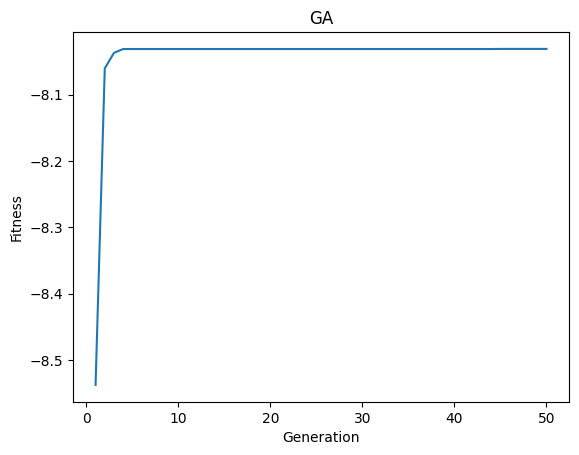

In [91]:
import matplotlib.pyplot as plt

plt.plot(generation_values, fitness_values)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('GA')
plt.show()

In [47]:
best_individual = [17, 35, 0.0004872495324492965, 9]
best_individual

[17, 35, 0.0004872495324492965, 9]

In [93]:
model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(
        random_state=42, 
        max_depth=best_individual[0], 
        min_samples_split=best_individual[1],
        ccp_alpha=best_individual[2],
        min_samples_leaf=best_individual[3]
    ))
])
model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=0.0004872495324492965,
                                       max_depth=17, min_samples_leaf=9,
                                       min_samples_split=35,
                                       random_state=42))])

In [53]:
genetic_model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(
        random_state=42, 
        max_depth=best_individual[0], 
        min_samples_split=best_individual[1],
        ccp_alpha=best_individual[2],
        min_samples_leaf=best_individual[3]
    ))
])
genetic_model.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=0.0004872495324492965,
                                       max_depth=17, min_samples_leaf=9,
                                       min_samples_split=35,
                                       random_state=42))])

In [94]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 3.942
MAE: 1.393
R2: 0.919

Test Set:
MSE: 7.143
MAE: 1.913
R2: 0.852


In [95]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.85061875 0.85025891 0.85117    0.83666176 0.83563459]
R^2 trung bình: 0.845 ± 0.007

MSE: [7.26375854 7.20143578 7.20489798 7.71463949 8.07029777]
MSE trung bình: 7.491± 0.347

MAE: [1.89770924 1.90693549 1.91371609 1.93118149 1.97919983]
MAE trung bình: 1.926 ± 0.029


In [ ]:
# from sklearn.tree import plot_tree

# plt.figure(figsize=(20, 10))
# plot_tree(model.named_steps['dt'], filled=True, feature_names=X.columns)
# plt.show()

In [96]:
from sklearn.tree import export_text

tree_rules = export_text(model.named_steps['dt'], feature_names=X.columns.tolist())
print(tree_rules)

|--- ball_control <= 68.50
|   |--- age <= 22.50
|   |   |--- ball_control <= 58.50
|   |   |   |--- standing_tackle <= 60.50
|   |   |   |   |--- nationality <= 65.58
|   |   |   |   |   |--- age <= 20.50
|   |   |   |   |   |   |--- ball_control <= 52.50
|   |   |   |   |   |   |   |--- marking <= 50.50
|   |   |   |   |   |   |   |   |--- positions_GK <= 0.50
|   |   |   |   |   |   |   |   |   |--- heading_accuracy <= 54.50
|   |   |   |   |   |   |   |   |   |   |--- ball_control <= 45.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- ball_control >  45.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |--- heading_accuracy >  54.50
|   |   |   |   |   |   |   |   |   |   |--- value: [54.20]
|   |   |   |   |   |   |   |   |--- positions_GK >  0.50
|   |   |   |   |   |   |   |   |   |--- age <= 19.50
|   |   |   |   |   |   |   |   |   |   |

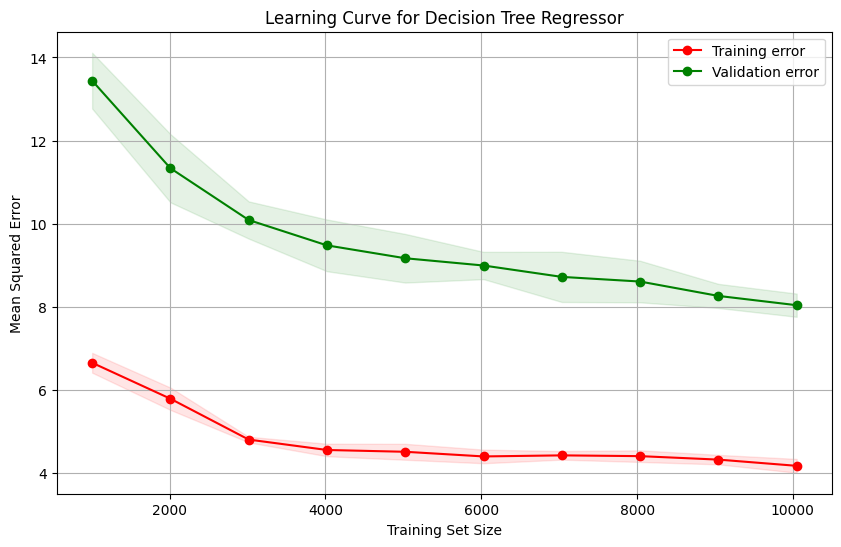

In [97]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train,
    y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve for Decision Tree Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation error")

plt.legend(loc="best")
plt.grid()
plt.show()

# Grid Search

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

param_grid = {
    'dt__max_depth': [12, 14, 16],
    'dt__min_samples_split': [2, 4, 6],
    'dt__ccp_alpha': [0.0005, 0.001],
    'dt__min_samples_leaf': [8, 16, 24, 32]
}

model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    model, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
)

search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('te',
                                        TargetEncoder(cols=['nationality'])),
                                       ('dt',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__ccp_alpha': [0.0005, 0.001],
                         'dt__max_depth': [12, 14, 16],
                         'dt__min_samples_leaf': [8, 16, 24, 32],
                         'dt__min_samples_split': [2, 4, 6]},
             scoring='neg_mean_squared_error')

In [16]:
best_params = search.best_params_
model = search.best_estimator_

print(model)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('dt',
                 DecisionTreeRegressor(ccp_alpha=0.0005, max_depth=16,
                                       min_samples_leaf=16, random_state=42))])


In [17]:
mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 4.222
MAE: 1.439
R2: 0.913

Test Set:
MSE: 7.050
MAE: 1.896
R2: 0.854


In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u" \u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.85249107 0.8497441  0.85171451 0.8368626  0.84241123]
R^2 trung bình: 0.847 ± 0.006

MSE: [7.17271565 7.22619437 7.17853842 7.70515348 7.73756687]
MSE trung bình: 7.404 ± 0.260

MAE: [1.8860103  1.91108719 1.92013488 1.91951014 1.93689998]
MAE trung bình: 1.915 ± 0.017


# Randomized Search 

In [19]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'dt__max_depth': np.arange(1, 30),
    'dt__min_samples_split': np.arange(2, 100),
    'dt__ccp_alpha': np.linspace(0, 0.1, 100),
    'dt__min_samples_leaf': np.arange(1, 50)
}

model = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('dt', DecisionTreeRegressor(random_state=42))
])

random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_grid, 
    n_iter=100, 
    cv=cv, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    random_state=42
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('te',
                                              TargetEncoder(cols=['nationality'])),
                                             ('dt',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'dt__ccp_alpha': array([0.        , 0.0010101 , 0.0020202 , 0.0030303 , 0.0040404 ,
       0.00505051, 0.00606061, 0.00707071, 0.00808081, 0.00909091,
       0...
                                        'dt__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   random_state=42, scoring='neg_mean_squared_error')

In [28]:
random_search.best_params_

{'dt__min_samples_split': np.int64(40),
 'dt__min_samples_leaf': np.int64(10),
 'dt__max_depth': np.int64(15),
 'dt__ccp_alpha': np.float64(0.0)}

In [29]:
model = search.best_estimator_

mse_train, mae_train, r2_train = evaluate_model(model, X_train, y_train)
print('Training Set:')
print_metrics(mse_train, mae_train, r2_train)

mse_test, mae_test, r2_test = evaluate_model(model, X_test, y_test)
print('\nTest Set:')
print_metrics(mse_test, mae_test, r2_test)

Training Set:
MSE: 4.222
MAE: 1.439
R2: 0.913

Test Set:
MSE: 7.050
MAE: 1.896
R2: 0.854


In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores: [0.85249107 0.8497441  0.85171451 0.8368626  0.84241123]
R^2 trung bình: 0.847 ± 0.006

MSE: [7.17271565 7.22619437 7.17853842 7.70515348 7.73756687]
MSE trung bình: 7.404± 0.260

MAE: [1.8860103  1.91108719 1.92013488 1.91951014 1.93689998]
MAE trung bình: 1.915 ± 0.017


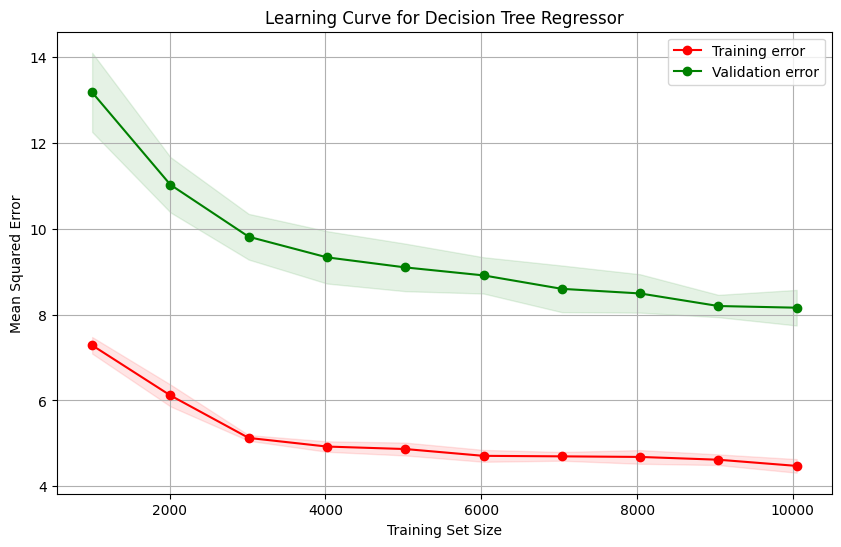

In [30]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train,
    y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve for Decision Tree Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation error")

plt.legend(loc="best")
plt.grid()
plt.show()

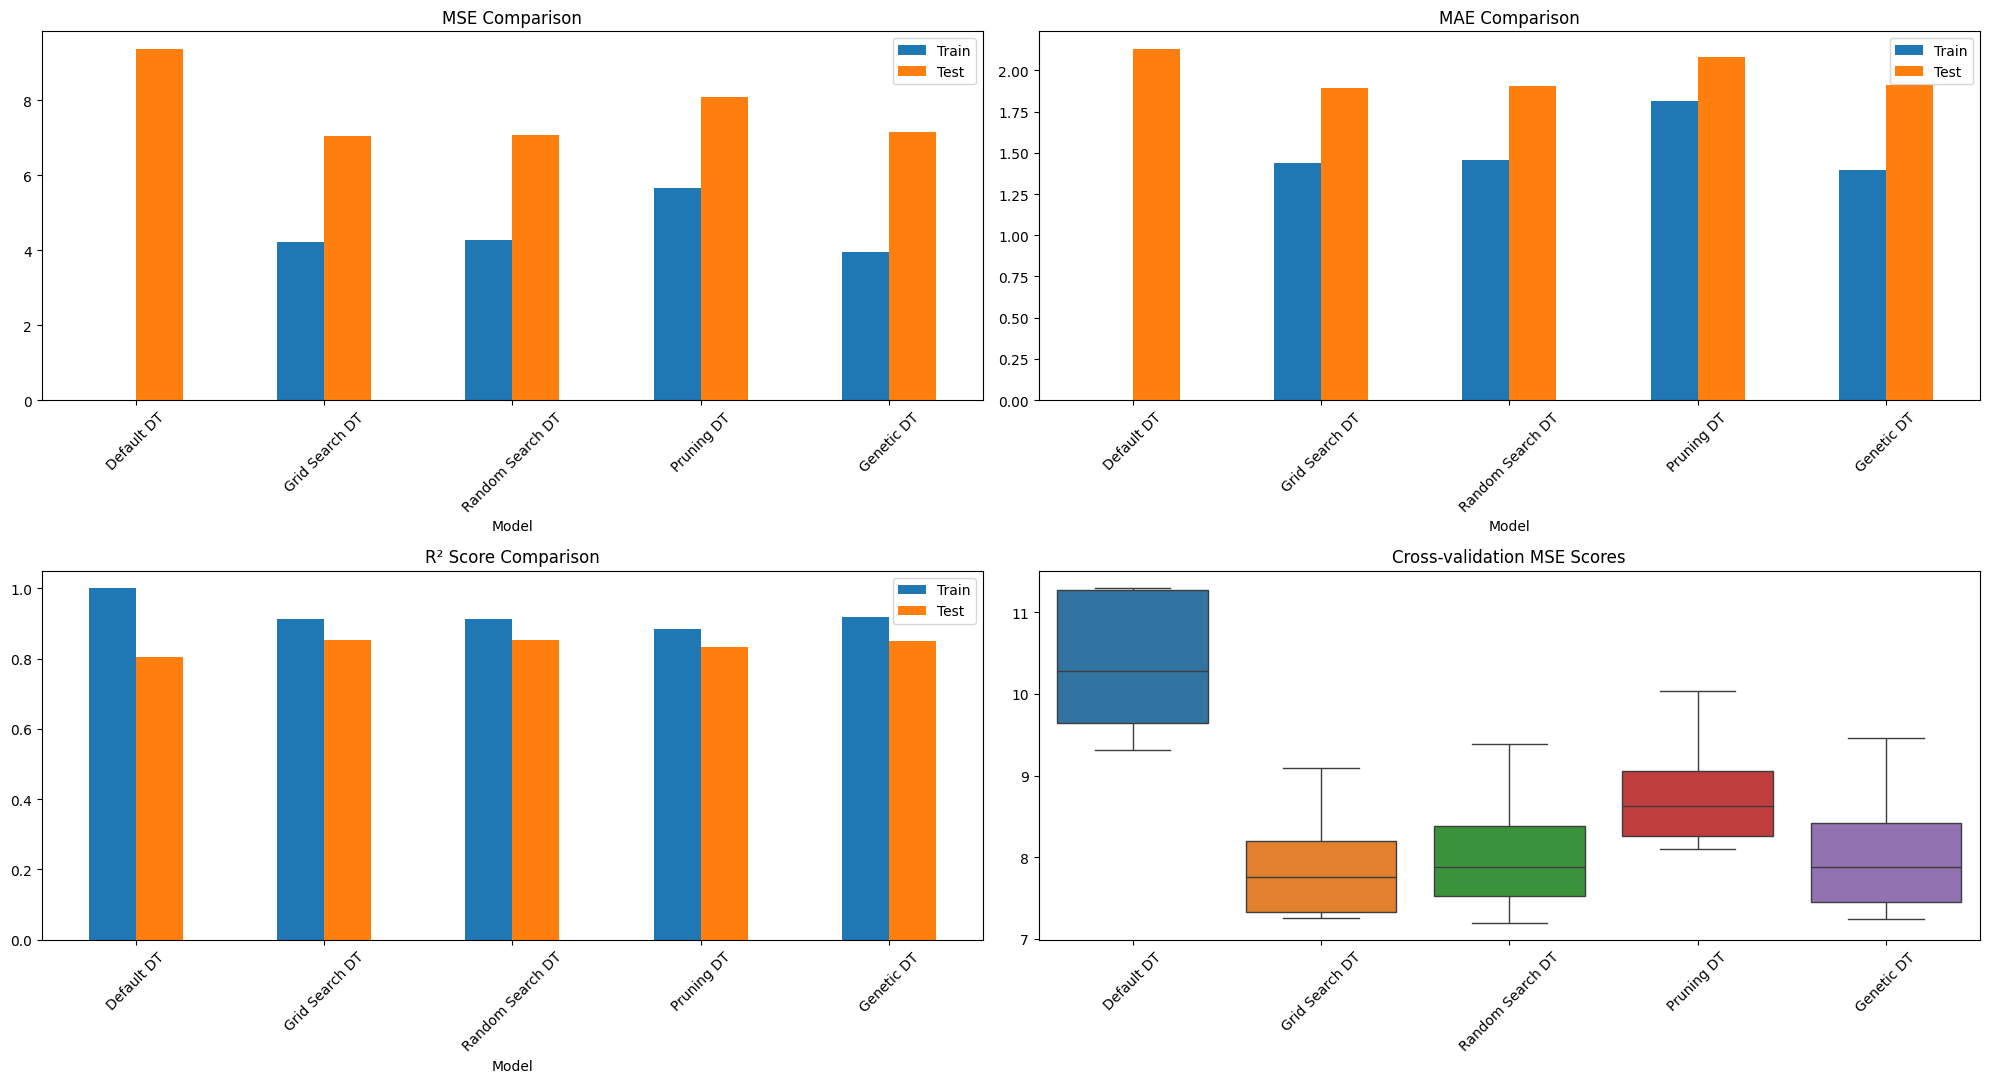


Detailed Performance Metrics:
----------------------------
                  Train MSE  Test MSE  Train MAE  Test MAE  Train R2  Test R2
Model                                                                        
Default DT           0.0000    9.3723     0.0000    2.1311    1.0000   0.8053
Grid Search DT       4.2223    7.0505     1.4394    1.8962    0.9127   0.8535
Random Search DT     4.2693    7.0774     1.4564    1.9083    0.9118   0.8530
Pruning DT           5.6467    8.0821     1.8125    2.0849    0.8833   0.8321
Genetic DT           3.9417    7.1431     1.3931    1.9128    0.9185   0.8516


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

def compare_multiple_models(models_dict, X_train, X_test, y_train, y_test, cv=5):
    # Collect predictions and metrics
    predictions = {}
    metrics = {
        'Model': [],
        'Train MSE': [],
        'Test MSE': [],
        'Train MAE': [],
        'Test MAE': [],
        'Train R2': [],
        'Test R2': []
    }
    
    cv_scores = {}
    residuals = {}
    
    for name, model in models_dict.items():
        # Get predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        predictions[name] = {'train': train_pred, 'test': test_pred}
        
        # Calculate metrics
        metrics['Model'].append(name)
        metrics['Train MSE'].append(mean_squared_error(y_train, train_pred))
        metrics['Test MSE'].append(mean_squared_error(y_test, test_pred))
        metrics['Train MAE'].append(mean_absolute_error(y_train, train_pred))
        metrics['Test MAE'].append(mean_absolute_error(y_test, test_pred))
        metrics['Train R2'].append(r2_score(y_train, train_pred))
        metrics['Test R2'].append(r2_score(y_test, test_pred))
        
        # Cross-validation scores
        cv_scores[name] = -cross_val_score(model, X_train, y_train, 
                                         cv=cv, scoring='neg_mean_squared_error')
    
    # 2. Create metrics DataFrame
    metrics_df = pd.DataFrame(metrics).set_index('Model')
    
    # 3. Visualizations
    # plt.style.use('seaborn')
    
    # 3.1 Performance Metrics Comparison
    fig = plt.figure(figsize=(20, 15))
    
    # MSE Comparison
    plt.subplot(321)
    metrics_comparison = pd.DataFrame({
        'Train': metrics_df['Train MSE'],
        'Test': metrics_df['Test MSE']
    }, index=metrics_df.index)
    metrics_comparison.plot(kind='bar', ax=plt.gca())
    plt.title('MSE Comparison')
    plt.xticks(rotation=45)
    
    # MAE Comparison
    plt.subplot(322)
    metrics_comparison = pd.DataFrame({
        'Train': metrics_df['Train MAE'],
        'Test': metrics_df['Test MAE']
    }, index=metrics_df.index)
    metrics_comparison.plot(kind='bar', ax=plt.gca())
    plt.title('MAE Comparison')
    plt.xticks(rotation=45)
    
    # R2 Comparison
    plt.subplot(323)
    metrics_comparison = pd.DataFrame({
        'Train': metrics_df['Train R2'],
        'Test': metrics_df['Test R2']
    }, index=metrics_df.index)
    metrics_comparison.plot(kind='bar', ax=plt.gca())
    plt.title('R² Score Comparison')
    plt.xticks(rotation=45)
    
    # Cross-validation Scores
    plt.subplot(324)
    cv_data = pd.DataFrame(cv_scores)
    sns.boxplot(data=cv_data)
    plt.title('Cross-validation MSE Scores')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("\nDetailed Performance Metrics:")
    print("----------------------------")
    print(metrics_df.round(4))

models = {
    'Default DT': default_model,
    'Grid Search DT': search.best_estimator_,
    'Random Search DT': random_search.best_estimator_,
    'Pruning DT': pruning_model,
    'Genetic DT': genetic_model
}

compare_multiple_models(
    models_dict=models,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

In [58]:
import joblib
import json
import os
from datetime import datetime

def save_dt_models(models_dict, base_folder='dt_models'):
    """
    Save Decision Tree models and their parameters
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary of models {'model_name': model}
    base_folder : str
        Base folder to save models
    """
    # Create timestamp for versioning
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_folder = os.path.join(base_folder, timestamp)
    os.makedirs(save_folder, exist_ok=True)
    
    # Save each model and its parameters
    for name, model in models_dict.items():
        print(f"\nSaving {name}...")
        
        # Create folder for this model
        model_folder = os.path.join(save_folder, name.replace(' ', '_'))
        os.makedirs(model_folder)
        
        # Save model parameters
        params = model.get_params()
        
        # Filter and convert parameters
        serializable_params = {}
        for k, v in params.items():
            # Skip TargetEncoder parameters
            if 'target_encoder' in str(v).lower():
                continue
            
            # Convert other non-serializable objects to their string representation
            if isinstance(v, (int, float, str, bool)):
                serializable_params[k] = v
            elif isinstance(v, (list, tuple)):
                # Handle lists/tuples of basic types
                if all(isinstance(x, (int, float, str, bool)) for x in v):
                    serializable_params[k] = list(v)
                else:
                    serializable_params[k] = str(v)
            elif isinstance(v, dict):
                # Handle dictionaries of basic types
                try:
                    json.dumps(v)  # Test if serializable
                    serializable_params[k] = v
                except:
                    serializable_params[k] = str(v)
            else:
                serializable_params[k] = str(v)
        
        # Save filtered parameters
        params_path = os.path.join(model_folder, 'parameters.json')
        with open(params_path, 'w') as f:
            json.dump(serializable_params, f, indent=4)
        
        # Save the model itself
        model_path = os.path.join(model_folder, 'model.joblib')
        joblib.dump(model, model_path)
        
        print(f"Model and parameters saved in: {model_folder}")
    
    print(f"\nAll models saved in: {save_folder}")
    return save_folder

def load_dt_models(folder_path):
    """
    Load saved Decision Tree models and their parameters
    
    Parameters:
    -----------
    folder_path : str
        Path to the folder containing saved models
    
    Returns:
    --------
    dict : Dictionary containing loaded models and their parameters
    """
    loaded_models = {}
    
    for model_name in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, model_name)):  # Check if it's a directory
            model_folder = os.path.join(folder_path, model_name)
            
            # Load parameters
            params_path = os.path.join(model_folder, 'parameters.json')
            with open(params_path, 'r') as f:
                params = json.load(f)
            
            # Load model
            model_path = os.path.join(model_folder, 'model.joblib')
            model = joblib.load(model_path)
            
            loaded_models[model_name.replace('_', ' ')] = {
                'model': model,
                'parameters': params
            }
    
    return loaded_models

# Save the models
models = {
    'Default DT': default_model,
    'Grid Search DT': search.best_estimator_,
    'Random Search DT': random_search.best_estimator_,
    'Pruning DT': pruning_model,
    'Genetic DT': genetic_model
}

# Save models
save_folder = save_dt_models(models)

# Load and compare models
loaded_models = load_dt_models(save_folder)

# Create parameter comparison DataFrame
def compare_parameters(loaded_models):
    """
    Compare parameters of different models
    """
    params_dict = {
        name: info['parameters'] 
        for name, info in loaded_models.items()
    }
    
    comparison_df = pd.DataFrame(params_dict).T
    return comparison_df

# Print parameter comparison
comparison_df = compare_parameters(loaded_models)
print("\nParameter Comparison:")
print("--------------------")
print(comparison_df)

# Save comparison to CSV
comparison_path = os.path.join(save_folder, 'parameter_comparison.csv')
comparison_df.to_csv(comparison_path)
print(f"\nParameter comparison saved to: {comparison_path}")


Saving Default DT...
Model and parameters saved in: dt_models\20241220_113127\Default_DT

Saving Grid Search DT...
Model and parameters saved in: dt_models\20241220_113127\Grid_Search_DT

Saving Random Search DT...
Model and parameters saved in: dt_models\20241220_113127\Random_Search_DT

Saving Pruning DT...
Model and parameters saved in: dt_models\20241220_113127\Pruning_DT

Saving Genetic DT...
Model and parameters saved in: dt_models\20241220_113127\Genetic_DT

All models saved in: dt_models\20241220_113127

Parameter Comparison:
--------------------
                 memory                                              steps  \
Default DT         None  [('te', TargetEncoder(cols=['nationality'])), ...   
Genetic DT         None  [('te', TargetEncoder(cols=['nationality'])), ...   
Grid Search DT     None  [('te', TargetEncoder(cols=['nationality'])), ...   
Pruning DT         None  [('te', TargetEncoder(cols=['nationality'])), ...   
Random Search DT   None  [('te', TargetEncoder(c